# b. 尝试使用 LoRA 微调 Stable Diffusion 模型（文生图）- 精简版

> 指导文章：[16. 用 LoRA 微调 Stable Diffusion：拆开炼丹炉，动手实现你的第一次 AI 绘画](https://github.com/Hoper-J/AI-Guide-and-Demos-zh_CN/blob/master/Guide/16.%20用%20LoRA%20微调%20Stable%20Diffusion：拆开炼丹炉，动手实现你的第一次%20AI%20绘画.md)

当前版本只保留了核心代码，并重新组织了函数的顺序，这次你可以两个版本都粗略运行，并选择其中一个版本深入学习。也因为精简版修改的东西比较多，所以不建议同时代入两个版本。最终训练效果一致。

注意，[版本 a](https://github.com/Hoper-J/AI-Guide-and-Demos-zh_CN/blob/master/Demos/14a.%20尝试使用%20LoRA%20微调%20Stable%20Diffusion%20模型.ipynb) 对于保存和加载使用的方法与版本 b 不同，精简版使用 PEFT 库直接完成，与之前的知识[《14. PEFT：在大模型中快速应用 LoRA》](https://github.com/Hoper-J/AI-Guide-and-Demos-zh_CN/blob/master/Guide/14.%20PEFT：在大模型中快速应用%20LoRA.md)对齐。

另外，我添加了一些 Emoji 在输出中，为之后的 Toy 脚本做准备 :)

## 安装必要的库

In [1]:
!pip install timm
!pip install fairscale
!pip install transformers
!pip install requests
!pip install accelerate
!pip install diffusers
!pip install einop
!pip install safetensors
!pip install voluptuous
!pip install jax
!pip install jaxlib
!pip install peft
!pip install deepface==0.0.90
!pip install tensorflow==2.9.0  # 为了避免最后评估阶段使用deepface时的错误，这里选择降级版本
!pip install keras
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fairscale: filename=fairscale-0.4.13-py3-none-any.whl size=332156 sha256=635da0f0d4864558cb0f9eb31deaedb787c9b3fa19f372e436d615c233beb2fa
  Stored in directory: /root/.cache/pip/wheels/95/ef/96/5044bde220b2ea299bdc6ec05051e0ef187fad45b341d1c273
Successfully built fairscale
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.4 MB/s eta 0:00:00
  Created whee

## 导入

In [2]:
# ========== 标准库模块 ==========
import os
import math
import glob
import shutil
import subprocess

# ========== 第三方库 ==========
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm.auto import tqdm

# ========== 深度学习相关库 ==========
from torchvision import transforms

# Transformers (Hugging Face)
from transformers import CLIPTextModel, CLIPTokenizer, CLIPModel, CLIPProcessor

# Diffusers (Hugging Face)
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    UNet2DConditionModel,
    DiffusionPipeline
)
from diffusers.optimization import get_scheduler
from diffusers.training_utils import compute_snr

# ========== LoRA 模型库 ==========
from peft import LoraConfig, get_peft_model, PeftModel

# ========== 面部检测库 ==========
from deepface import DeepFace

import cv2

25-01-17 08:19:07 - Directory /root/.deepface created
25-01-17 08:19:07 - Directory /root/.deepface/weights created


## 准备项目

### 设置路径
这里的参数不需要修改，如果你想自定义文件夹，后续我会出一个更通用的脚本供你学习。

当你看见✅时，代表项目已经准备好。

In [3]:
# 项目名称和数据集名称
project_name = "Brad"
dataset_name = "Brad"

# 根目录和主要目录
root_dir = "./"  # 当前目录
main_dir = os.path.join(root_dir, "SD")  # 主目录

# 项目目录
project_dir = os.path.join(main_dir, project_name)  # 项目目录

# 数据集和模型路径
images_folder = os.path.join(main_dir, "Datasets", dataset_name)
prompts_folder = os.path.join(main_dir, "Datasets", "prompts")
captions_folder = images_folder  # 与原始代码一致
output_folder = os.path.join(project_dir, "logs")  # 存放 model checkpoints 和 validation 的文件夹

# prompt 文件路径
validation_prompt_name = "validation_prompt.txt"
validation_prompt_path = os.path.join(prompts_folder, validation_prompt_name)

# 模型检查点路径
model_path = os.path.join(project_dir, "logs", "checkpoint-last")

# 其他路径设置
zip_file = os.path.join(main_dir, "Datasets.zip")
inference_path = os.path.join(project_dir, "inference")  # 保存推理结果的文件夹

os.makedirs(images_folder, exist_ok=True)
os.makedirs(prompts_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)
os.makedirs(inference_path, exist_ok=True)

# 检查并解压数据集
print("📂 正在下载并解压样例数据集...")
!gdown 1OXPG2vNb8bG2334HML8vKpqo8UbAEV3d -O {zip_file}
if not os.path.exists(zip_file):
    print("❌ 未找到数据集压缩文件 Datasets.zip！")
else:
    subprocess.run(f"unzip -q -o {zip_file} -d {main_dir}", shell=True)
    print(f"✅ 项目 {project_name} 已准备好！")

📂 正在下载并解压样例数据集...
Downloading...
From: https://drive.google.com/uc?id=1OXPG2vNb8bG2334HML8vKpqo8UbAEV3d
To: /content/SD/Datasets.zip
100% 2.78M/2.78M [00:00<00:00, 22.4MB/s]
✅ 项目 Brad 已准备好！


## 定义一些有用的函数和类

### 数据集

In [4]:
# 图片后缀，不用关注
IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg", ".webp", ".bmp", ".PNG", ".JPG", ".JPEG", ".WEBP", ".BMP"]

class Text2ImageDataset(torch.utils.data.Dataset):
    """
    (1) 目标:
        - 用于构建文本到图像模型的微调数据集
    """
    def __init__(self, images_folder, captions_folder, transform, tokenizer):
        """
        (2) 参数:
            - images_folder: str, 图像文件夹路径
            - captions_folder: str, 标注文件夹路径
            - transform: function, 将原始图像转换为 torch.Tensor
            - tokenizer: CLIPTokenizer, 将文本标注转为 word ids
        """
        # 初始化图像路径列表，并根据指定的扩展名找到所有图像文件
        self.image_paths = []
        for ext in IMAGE_EXTENSIONS:
            self.image_paths.extend(glob.glob(os.path.join(images_folder, f"*{ext}")))
        self.image_paths = sorted(self.image_paths)

        # 加载对应的文本标注，依次读取每个文本文件中的内容
        caption_paths = sorted(glob.glob(os.path.join(captions_folder, "*.txt")))
        captions = []
        for p in caption_paths:
            with open(p, "r", encoding="utf-8") as f:
                captions.append(f.readline().strip())

        # 确保图像和文本标注数量一致
        if len(captions) != len(self.image_paths):
            raise ValueError("图像数量与文本标注数量不一致，请检查数据集。")

        # 使用 tokenizer 将文本标注转换为 word ids
        inputs = tokenizer(
            captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        self.input_ids = inputs.input_ids
        self.transform = transform

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        input_id = self.input_ids[idx]
        try:
            # 加载图像并将其转换为 RGB 模式，然后应用数据增强
            image = Image.open(img_path).convert("RGB")
            tensor = self.transform(image)
        except Exception as e:
            print(f"⚠️ 无法加载图像路径: {img_path}, 错误: {e}")
            # 返回一个全零的张量和空的输入 ID 以避免崩溃
            tensor = torch.zeros((3, resolution, resolution))
            input_id = torch.zeros_like(input_id)

        return tensor, input_id  # 返回处理后的图像和相应的文本标注

    def __len__(self):
        return len(self.image_paths)

### 加载 LoRA

In [5]:
def prepare_lora_model(lora_config, pretrained_model_name_or_path, model_path=None, resume=False, merge_lora=False):
    """
    (1) 目标:
        - 加载完整的 Stable Diffusion 模型，包括 LoRA 层，并根据需要合并 LoRA 权重。这包括 Tokenizer、噪声调度器、UNet、VAE 和文本编码器。

    (2) 参数:
        - lora_config: LoraConfig, LoRA 的配置对象
        - pretrained_model_name_or_path: str, Hugging Face 上的模型名称或路径
        - model_path: str, 预训练模型的路径
        - resume: bool, 是否从上一次训练中恢复
        - merge_lora: bool, 是否在推理时合并 LoRA 权重

    (3) 返回:
        - tokenizer: CLIPTokenizer
        - noise_scheduler: DDPMScheduler
        - unet: UNet2DConditionModel
        - vae: AutoencoderKL
        - text_encoder: CLIPTextModel
    """
    # 加载噪声调度器，用于控制扩散模型的噪声添加和移除过程
    noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")

    # 加载 Tokenizer，用于将文本标注转换为 tokens
    tokenizer = CLIPTokenizer.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="tokenizer"
    )

    # 加载 CLIP 文本编码器，用于将文本标注转换为特征向量
    text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path,
        torch_dtype=weight_dtype,
        subfolder="text_encoder"
    )

    # 加载 VAE 模型，用于在扩散模型中处理图像的潜在表示
    vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="vae"
    )

    # 加载 UNet 模型，负责处理扩散模型中的图像生成和推理过程
    unet = UNet2DConditionModel.from_pretrained(
        pretrained_model_name_or_path,
        torch_dtype=weight_dtype,
        subfolder="unet"
    )

    # 如果设置为继续训练，则加载上一次的模型权重
    if resume:
        if model_path is None or not os.path.exists(model_path):
            raise ValueError("当 resume 设置为 True 时，必须提供有效的 model_path")
        # 使用 PEFT 的 from_pretrained 方法加载 LoRA 模型
        text_encoder = PeftModel.from_pretrained(text_encoder, os.path.join(model_path, "text_encoder"))
        unet = PeftModel.from_pretrained(unet, os.path.join(model_path, "unet"))

        # 确保 UNet 的可训练参数的 requires_grad 为 True
        for param in unet.parameters():
            if param.requires_grad is False:
                param.requires_grad = True

        # 确保文本编码器的可训练参数的 requires_grad 为 True
        for param in text_encoder.parameters():
            if param.requires_grad is False:
                param.requires_grad = True

        print(f"✅ 已从 {model_path} 恢复模型权重")

    else:
        # 将 LoRA 配置应用到 text_encoder 和 unet
        text_encoder = get_peft_model(text_encoder, lora_config)
        unet = get_peft_model(unet, lora_config)

        # 打印可训练参数数量
        print("📊 Text Encoder 可训练参数:")
        text_encoder.print_trainable_parameters()
        print("📊 UNet 可训练参数:")
        unet.print_trainable_parameters()

    if merge_lora:
        # 合并 LoRA 权重到基础模型，仅在推理时调用
        text_encoder = text_encoder.merge_and_unload()
        unet = unet.merge_and_unload()

        # 切换为评估模式
        text_encoder.eval()
        unet.eval()

    # 冻结 VAE 参数
    vae.requires_grad_(False)

    # 将模型移动到 GPU 上并设置权重的数据类型
    unet.to(DEVICE, dtype=weight_dtype)
    vae.to(DEVICE, dtype=weight_dtype)
    text_encoder.to(DEVICE, dtype=weight_dtype)

    return tokenizer, noise_scheduler, unet, vae, text_encoder

### 准备优化器

In [6]:
def prepare_optimizer(unet, text_encoder, unet_learning_rate=5e-4, text_encoder_learning_rate=1e-4):
    """
    (1) 目标:
        - 为 UNet 和文本编码器的可训练参数分别设置优化器，并指定不同的学习率。

    (2) 参数:
        - unet: UNet2DConditionModel, Hugging Face 的 UNet 模型
        - text_encoder: CLIPTextModel, Hugging Face 的文本编码器
        - unet_learning_rate: float, UNet 的学习率
        - text_encoder_learning_rate: float, 文本编码器的学习率

    (3) 返回:
        - 输出: 优化器 Optimizer
    """
    # 筛选出 UNet 中需要训练的 Lora 层参数
    unet_lora_layers = [p for p in unet.parameters() if p.requires_grad]

    # 筛选出文本编码器中需要训练的 Lora 层参数
    text_encoder_lora_layers = [p for p in text_encoder.parameters() if p.requires_grad]

    # 将需要训练的参数分组并设置不同的学习率
    trainable_params = [
        {"params": unet_lora_layers, "lr": unet_learning_rate},
        {"params": text_encoder_lora_layers, "lr": text_encoder_learning_rate}
    ]

    # 使用 AdamW 优化器
    optimizer = torch.optim.AdamW(trainable_params)

    return optimizer

### 定义 collate_fn 函数

In [7]:
def collate_fn(examples):
    pixel_values = []
    input_ids = []

    for tensor, input_id in examples:
        pixel_values.append(tensor)
        input_ids.append(input_id)

    pixel_values = torch.stack(pixel_values, dim=0).float()
    input_ids = torch.stack(input_ids, dim=0)

    # 如果你喜欢列表推导式的话，使用下面的方法
    #pixel_values = torch.stack([example[0] for example in examples], dim=0).float()
    #input_ids = torch.stack([example[1] for example in examples], dim=0)

    return {"pixel_values": pixel_values, "input_ids": input_ids}

## 参数设置

### 1. 设备配置

In [8]:
# 设备配置
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For Mac M1, M2...
# DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

print(f"🖥 当前使用的设备: {DEVICE}")

🖥 当前使用的设备: cuda


### 2. 图像预处理与数据增强

In [9]:
# 训练图像的分辨率
resolution = 512

# 数据增强操作
train_transform = transforms.Compose(
    [
        transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR),  # 调整图像大小
        transforms.CenterCrop(resolution),  # 中心裁剪图像
        transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.ToTensor(),  # 将图像转换为张量
    ]
)

### 3. 模型与训练参数配置

In [10]:
# 训练相关参数
train_batch_size = 2  # 训练批次大小，即每次训练中处理的样本数量
weight_dtype = torch.bfloat16  # 权重数据类型，使用 bfloat16 以节省内存并加快计算速度
snr_gamma = 5  # SNR 参数，用于信噪比加权损失的调节系数

# 设置随机数种子以确保可重复性
seed = 1126  # 随机数种子
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Stable Diffusion LoRA 的微调参数

# 优化器参数
# 大的学习率 会导致 人很像ghosthuman（训练和测试结果的欧氏距离）分数高 但文字描述不同CLIP分数低
unet_learning_rate = 1e-4  # UNet 的学习率，控制 UNet 参数更新的步长
text_encoder_learning_rate = 1e-4  # 文本编码器的学习率，控制文本嵌入层的参数更新步长

# 学习率调度器参数
lr_scheduler_name = "cosine_with_restarts"  # 设置学习率调度器为 Cosine annealing with restarts，逐渐减少学习率并定期重启
lr_warmup_steps = 100  # 学习率预热步数，在最初的 100 步中逐渐增加学习率到最大值
max_train_steps = 200  # 总训练步数，决定了整个训练过程的迭代次数
num_cycles = 3  # Cosine 调度器的周期数量，在训练期间会重复 3 次学习率周期性递减并重启

# 预训练的 Stable Diffusion 模型路径，用于加载模型进行微调
pretrained_model_name_or_path = "stablediffusionapi/cyberrealistic-41"

# LoRA 配置
lora_config = LoraConfig(
    r=32,  # LoRA 的秩，即低秩矩阵的维度，决定了参数调整的自由度
    lora_alpha=16,  # 缩放系数，控制 LoRA 权重对模型的影响
    target_modules=[
        "q_proj", "v_proj", "k_proj", "out_proj",  # 指定 Text encoder 的 LoRA 应用对象（用于调整注意力机制中的投影矩阵）
        "to_k", "to_q", "to_v", "to_out.0"  # 指定 UNet 的 LoRA 应用对象（用于调整 UNet 中的注意力机制）
    ],
    lora_dropout=0  # LoRA dropout 概率，0 表示不使用 dropout
)

## 微调前的准备

### 1. 数据集

In [11]:
# 初始化 tokenizer，用于加载数据集
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer"
)

# 准备数据集
dataset = Text2ImageDataset(
    images_folder=images_folder,
    captions_folder=captions_folder,
    transform=train_transform,
    tokenizer=tokenizer,
)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=train_batch_size,
    num_workers=8,
)

print("✅ 数据集准备完成！")

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

✅ 数据集准备完成！


### 2. 模型和优化器

In [12]:
# 准备模型
tokenizer, noise_scheduler, unet, vae, text_encoder = prepare_lora_model(
    lora_config,
    pretrained_model_name_or_path,
    model_path,
    resume=False,  # 根据需要设置为 True 以从 checkpoint 恢复
    merge_lora=False  # 是否合并 LoRA 权重
)

# 准备优化器
optimizer = prepare_optimizer(
    unet,
    text_encoder,
    unet_learning_rate=unet_learning_rate,
    text_encoder_learning_rate=text_encoder_learning_rate
)

# 设置学习率调度器
lr_scheduler = get_scheduler(
    lr_scheduler_name,
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=max_train_steps,
    num_cycles=num_cycles
)

print("✅ 模型和优化器准备完成！可以开始训练。")


scheduler/scheduler_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

An error occurred while trying to fetch stablediffusionapi/cyberrealistic-41: stablediffusionapi/cyberrealistic-41 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

An error occurred while trying to fetch stablediffusionapi/cyberrealistic-41: stablediffusionapi/cyberrealistic-41 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

📊 Text Encoder 可训练参数:
trainable params: 2,359,296 || all params: 125,419,776 || trainable%: 1.8811
📊 UNet 可训练参数:
trainable params: 6,377,472 || all params: 865,898,436 || trainable%: 0.7365
✅ 模型和优化器准备完成！可以开始训练。


## 开始微调

让diffusion model记住a man代表那个美国男明星

In [13]:
# 禁用并行化，避免警告
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 初始化
global_step = 0
best_face_score = float("inf")  # 初始化为正无穷大，存储最佳面部相似度分数

# 进度条显示训练进度
progress_bar = tqdm(
    range(max_train_steps),  # 根据 num_training_steps 设置
    desc="训练步骤",
)

# 训练循环
for epoch in range(math.ceil(max_train_steps / len(train_dataloader))):
    # 如果你想在训练中增加评估，那在循环中增加 train() 是有必要的
    unet.train()
    text_encoder.train()

    for step, batch in enumerate(train_dataloader):
        if global_step >= max_train_steps:
            break

        # 编码图像为潜在表示（latent）
        latents = vae.encode(batch["pixel_values"].to(DEVICE, dtype=weight_dtype)).latent_dist.sample()
        latents = latents * vae.config.scaling_factor  # 根据 VAE 的缩放因子调整潜在空间

        # 为潜在表示添加噪声，生成带噪声的图像
        noise = torch.randn_like(latents)  # 生成与潜在表示相同形状的随机噪声
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=DEVICE).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # 获取文本的嵌入表示
        encoder_hidden_states = text_encoder(batch["input_ids"].to(DEVICE))[0]

        # 计算目标值
        if noise_scheduler.config.prediction_type == "epsilon":
            target = noise  # 预测噪声
        elif noise_scheduler.config.prediction_type == "v_prediction":
            target = noise_scheduler.get_velocity(latents, noise, timesteps)  # 预测速度向量

        # UNet 模型预测
        # 这里是预测噪声。 timestep是第几步。 根据第几步来预测噪声的程度
        # encoder_hidden_states是文字的embed
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states)[0]

        # 计算损失
        if not snr_gamma:
            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
        else:
            # 计算信噪比 (SNR) 并根据 SNR 加权 MSE 损失
            snr = compute_snr(noise_scheduler, timesteps)
            mse_loss_weights = torch.stack([snr, snr_gamma * torch.ones_like(timesteps)], dim=1).min(dim=1)[0]
            if noise_scheduler.config.prediction_type == "epsilon":
                mse_loss_weights = mse_loss_weights / snr
            elif noise_scheduler.config.prediction_type == "v_prediction":
                mse_loss_weights = mse_loss_weights / (snr + 1)

            # 计算加权的 MSE 损失
            loss = F.mse_loss(model_pred.float(), target.float(), reduction="none")
            loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
            loss = loss.mean()

        # 反向传播
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        global_step += 1

        # 打印训练损失
        if global_step % 100 == 0 or global_step == max_train_steps:
            print(f"🔥 步骤 {global_step}, 损失: {loss.item()}")

        # 保存中间检查点，当前简单设置为每 500 步保存一次
        if global_step % 500 == 0:
            save_path = os.path.join(output_folder, f"checkpoint-{global_step}")
            os.makedirs(save_path, exist_ok=True)

            # 使用 save_pretrained 保存 PeftModel
            unet.save_pretrained(os.path.join(save_path, "unet"))
            text_encoder.save_pretrained(os.path.join(save_path, "text_encoder"))
            print(f"💾 已保存中间模型到 {save_path}")

# 保存最终模型到 checkpoint-last
save_path = os.path.join(output_folder, "checkpoint-last")
os.makedirs(save_path, exist_ok=True)
unet.save_pretrained(os.path.join(save_path, "unet"))
text_encoder.save_pretrained(os.path.join(save_path, "text_encoder"))
print(f"💾 已保存最终模型到 {save_path}")

print("🎉 微调完成！")

训练步骤:   0%|          | 0/200 [00:00<?, ?it/s]

🔥 步骤 100, 损失: 0.0426207073032856
🔥 步骤 200, 损失: 0.1762157380580902
💾 已保存最终模型到 ./SD/Brad/logs/checkpoint-last
🎉 微调完成！


## 生成图像和测试

### 加载用于验证的 prompts


In [14]:
def load_validation_prompts(validation_prompt_path):
    """
    (1) 目标:
        - 加载验证提示文本。

    (2) 参数:
        - validation_prompt_path: str, 验证提示文件的路径

    (3) 返回:
        - validation_prompt: list, 验证提示的字符串列表，每一行就是一个prompt
    """
    with open(validation_prompt_path, "r", encoding="utf-8") as f:
        validation_prompt = [line.strip() for line in f.readlines()]
    return validation_prompt

### 定义生成图像的函数

In [15]:
def generate_images(pipeline, prompts, num_inference_steps=50, guidance_scale=7.5, output_folder="inference", generator=None):
    """
    (1) 目标:
        - 使用 DiffusionPipeline 生成图像，保存到指定文件夹并返回生成的图像列表。

    (2) 参数:
        - pipeline: DiffusionPipeline, 已加载并配置好的 Pipeline
        - prompts: list, 文本提示列表
        - num_inference_steps: int, 推理步骤数，越高图像质量越好，但推理时间也会增加
        - guidance_scale: float, 决定文本提示对生成图像的影响程度
        - output_folder: str, 保存生成图像的文件夹路径
        - generator: torch.Generator, 控制生成随机数的种子，确保图像生成的一致性。如果不提供，生成的图像每次可能不同

    (3) 返回:
        - 生成的图像列表，同时图像也会保存到指定文件夹。
    """
    print("🎨 正在生成图像...")
    os.makedirs(output_folder, exist_ok=True)
    generated_images = []

    for i, prompt in enumerate(tqdm(prompts, desc="生成图像中")):
        # 使用 pipeline 生成图像
        image = pipeline(prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, generator=generator).images[0]

        # 保存图像到指定文件夹
        save_file = os.path.join(output_folder, f"generated_{i+1}.png")
        image.save(save_file)

        # 将图像保存到列表中，稍后返回
        generated_images.append(image)

    print(f"✅ 已生成并保存 {len(prompts)} 张图像到 {output_folder}")

    return generated_images

### 定义评估函数

In [16]:
def evaluate(lora_config):
    """
    加载模型、生成图像并评估。

    主要步骤：
    1. 加载验证文本提示（prompts）用于生成图像。
    2. 加载和准备 LoRA 微调后的模型。
    3. 使用 DiffusionPipeline 生成图像。
    4. 评估生成图像的人脸相似度、CLIP 评分和无面部图像数量。
    5. 打印评估结果。
    """
    print("📂 加载验证提示...")
    validation_prompts = load_validation_prompts(validation_prompt_path)

    print("🔧 准备 LoRA 模型...")
    # 准备 LoRA 模型（用于推理，合并权重）
    tokenizer, noise_scheduler, unet, vae, text_encoder = prepare_lora_model(
        lora_config,
        pretrained_model_name_or_path,
        model_path=model_path,
        resume=True,  # 从检查点恢复
        merge_lora=True  # 合并 LoRA 权重
    )

    # 创建 DiffusionPipeline 并更新其组件
    print("🔄 创建 DiffusionPipeline...")
    pipeline = DiffusionPipeline.from_pretrained(
        pretrained_model_name_or_path,
        unet=unet,  # 传递基础模型
        text_encoder=text_encoder,  # 传递基础模型
        torch_dtype=weight_dtype,
        safety_checker=None,
    )
    pipeline = pipeline.to(DEVICE)

    # 加载 CLIP 模型和处理器
    print("🎯 加载 CLIP 模型...")
    clip_model_name = "openai/clip-vit-base-patch32"
    clip_model = CLIPModel.from_pretrained(clip_model_name).to(DEVICE)
    clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

    # CLIP 模型设置为评估模式
    clip_model.eval()

    # 设置随机数种子
    generator = torch.Generator(device=DEVICE)
    generator.manual_seed(seed)

    # 加载训练图像的面部嵌入
    print("📂 加载训练图像的面部嵌入...")
    # any（True,false） == True  只要有一个true计算 true
    train_image_paths = sorted([
        p for p in glob.glob(os.path.join(images_folder, "*"))
        if any(p.endswith(ext) for ext in IMAGE_EXTENSIONS)
    ])
    train_emb_list = []
    for img_path in tqdm(train_image_paths, desc="提取训练图像面部嵌入"):
        face_representation = DeepFace.represent(
            img_path,
            detector_backend="ssd",
            model_name="Facenet",
            enforce_detection=False
        )
        if face_representation:
            embedding = face_representation[0]['embedding']
            train_emb_list.append(embedding)

    if len(train_emb_list) == 0:
        print("⚠️ 未能提取到任何训练图像的面部嵌入。")
        train_emb = torch.tensor([]).to(DEVICE)
    else:
        train_emb = torch.tensor(train_emb_list).to(DEVICE)

    # 生成图像
    generated_images = generate_images(
        pipeline=pipeline,
        prompts=validation_prompts,
        num_inference_steps=30,
        guidance_scale=7.5,
        output_folder=inference_path,
        # generator=generator
    )

    # 评估生成的图像，mis记录无法检测到面部的图像数量
    face_score, clip_score, mis = 0, 0, 0  # 初始化评估分数和计数
    valid_emb = []
    print("📊 正在计算评估分数...")

    for i, image in enumerate(tqdm(generated_images, desc="评估图像中")):
        # 使用 DeepFace 检测面部特征
        opencvImage = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        emb = DeepFace.represent(
            opencvImage,
            detector_backend="ssd",
            model_name="Facenet",
            enforce_detection=False,
        )
        if not emb or emb[0].get('face_confidence', 0) == 0:
            mis += 1  # 无法检测到面部的图像数量
            continue

        # 计算 CLIP 分数
        current_prompt = validation_prompts[i]
        inputs = clip_processor(text=current_prompt, images=image, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            outputs = clip_model(**inputs)
        sim = outputs.logits_per_image
        clip_score += sim.item()

        # 收集有效的面部嵌入
        valid_emb.append(emb[0]['embedding'])

    # 如果没有有效的面部嵌入，则返回默认分数
    if len(valid_emb) == 0:
        print("⚠️ 无法检测到面部嵌入！")
        return 0, 0, mis

    # 计算面部相似度分数（使用欧氏距离）
    valid_emb = torch.tensor(valid_emb).to(DEVICE)
    valid_emb = valid_emb / valid_emb.norm(p=2, dim=-1, keepdim=True)
    train_emb = train_emb / train_emb.norm(p=2, dim=-1, keepdim=True)
    face_distance = torch.cdist(valid_emb, train_emb, p=2).mean().item()
    face_score = face_distance  # 平均欧氏距离作为面部相似性分数
    clip_score /= (len(validation_prompts) - mis) if (len(validation_prompts) - mis) > 0 else 1
    print("📈 评估完成！")

    # 打印评估结果
    print(f"✅ 面部相似度评分 (平均欧氏距离): {face_score:.4f} (越低越好，表示生成图像与训练图像更相似)")
    print(f"✅ CLIP 评分 (平均相似度): {clip_score:.4f} (越高越好，表示生成图像与文本提示的相关性更强)")
    print(f"✅ 无面部图像数量: {mis} (无法检测到面部的生成图像数量)")

# 调用函数执行
evaluate(lora_config)

📂 加载验证提示...
🔧 准备 LoRA 模型...


An error occurred while trying to fetch stablediffusionapi/cyberrealistic-41: stablediffusionapi/cyberrealistic-41 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch stablediffusionapi/cyberrealistic-41: stablediffusionapi/cyberrealistic-41 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


✅ 已从 ./SD/Brad/logs/checkpoint-last 恢复模型权重
🔄 创建 DiffusionPipeline...


model_index.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stablediffusionapi--cyberrealistic-41/snapshots/ce594402a2f6525cb11bf93f219889b5fc62d3ba/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stablediffusionapi--cyberrealistic-41/snapshots/ce594402a2f6525cb11bf93f219889b5fc62d3ba/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or 

🎯 加载 CLIP 模型...


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

📂 加载训练图像的面部嵌入...


提取训练图像面部嵌入:   0%|          | 0/100 [00:00<?, ?it/s]

25-01-17 08:35:20 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5


  0%|          | 0.00/92.2M [00:00<?, ?B/s]

 12%|█▏        | 11.0M/92.2M [00:00<00:00, 87.4MB/s]

 31%|███       | 28.3M/92.2M [00:00<00:00, 132MB/s] 

 46%|████▌     | 42.5M/92.2M [00:00<00:00, 116MB/s]

 59%|█████▉    | 54.5M/92.2M [00:00<00:00, 82.6MB/s]

 71%|███████   | 65.5M/92.2M [00:00<00:00, 89.7MB/s]

100%|██████████| 92.2M/92.2M [00:00<00:00, 106MB/s]


25-01-17 08:35:22 - deploy.prototxt will be downloaded...


Downloading...
From: https://github.com/opencv/opencv/raw/3.4.0/samples/dnn/face_detector/deploy.prototxt
To: /root/.deepface/weights/deploy.prototxt


28.1kB [00:00, 23.5MB/s]                   


25-01-17 08:35:22 - res10_300x300_ssd_iter_140000.caffemodel will be downloaded...


Downloading...
From: https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
To: /root/.deepface/weights/res10_300x300_ssd_iter_140000.caffemodel


100%|██████████| 10.7M/10.7M [00:00<00:00, 159MB/s]


🎨 正在生成图像...


生成图像中:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

✅ 已生成并保存 25 张图像到 ./SD/Brad/inference
📊 正在计算评估分数...


评估图像中:   0%|          | 0/25 [00:00<?, ?it/s]

📈 评估完成！
✅ 面部相似度评分 (平均欧氏距离): 1.2555 (越低越好，表示生成图像与训练图像更相似)
✅ CLIP 评分 (平均相似度): 31.6366 (越高越好，表示生成图像与文本提示的相关性更强)
✅ 无面部图像数量: 0 (无法检测到面部的生成图像数量)


生成图像路径：

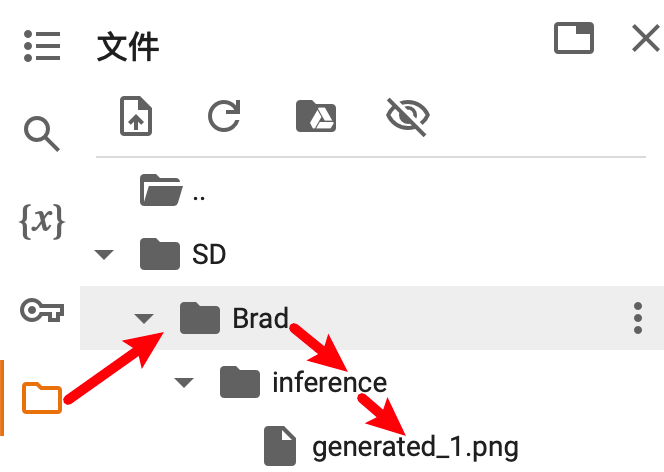